<a href="https://colab.research.google.com/github/ssrbazpur/Envisioning-Yellow-Taxi-High-Demand-Areas-in-NYC-city/blob/master/Model_Planning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3><center><b><u>Model Planning</u></b></center> </h3>
<h4><center><b>Prepared By: Simranjeet Randhawa</b></center> </h4>
<h4><center><b>Student ID: 200412297</b></center> </h4>




<h3> <b> 1. Model Planning with Data Exploration </b> </h3>
<p align="justify">
Data Exploration is the phase where one tries to understand the data in hand and how the different variables interact between each other. In Machine Learning, Data Exploration always precede the creation of the predictive model as it allows us to come up with ideas in order to increase the models’ performances.
</p>

https://datastudio.google.com/reporting/4c1a8825-32ec-44ab-8c34-19e988839087

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/content/drive/My Drive/Data Science/nyc-taxi-265120-baf9a3e4cf9b.json"
%reload_ext google.cloud.bigquery

In [0]:
project_id = 'nyc-taxi-265120' 
from google.cloud import bigquery
client = bigquery.Client(project = project_id)

<h3> <b> 2. Model Planning - Feature Engineering </b> </h3>
<p align="justify">
In model planning,the methods, techniques, and workflow is being determined. In this phase the data is explored to learn about the relationships between variables and subsequently selects key variables and the most suitable models.
</p>

In [0]:
query = """
SELECT  * FROM `hello.CombinedData`
"""
data = client.query(query).to_dataframe()

<b>One Hot Encoding </b>
<p align="justify"> The zone_id is a categorical variable. One hot encoding can be used to align zone_id column wise. It will be helpful to train our model</p>

In [5]:
data.head()

,zone_id,time,pickups
0,107,2019-07-01 03:00:00+00:00,13.0
1,107,2019-07-09 03:00:00+00:00,13.0
2,107,2019-08-07 03:00:00+00:00,13.0
3,107,2019-09-03 02:00:00+00:00,13.0
4,107,2019-09-03 04:00:00+00:00,13.0


In [0]:
#______ONE HOT ENCODING____

import pandas as pd
one_hot = pd.get_dummies(data['zone_id'])

In [8]:
one_hot.head()

,1,10,100,101,102,106,107,108,109,11,110,111,112,113,114,115,116,117,118,119,12,120,121,122,123,124,125,126,127,128,129,13,130,131,132,133,134,135,136,137,...,63,64,65,66,67,68,69,7,70,71,72,73,74,75,76,77,78,79,8,80,81,82,83,84,85,86,87,88,89,9,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
data = data.drop('zone_id',axis = 1)
# Join the encoded df
data = data.join(one_hot)

In [11]:
data.head()

,time,pickups,1,10,100,101,102,106,107,108,109,11,110,111,112,113,114,115,116,117,118,119,12,120,121,122,123,124,125,126,127,128,129,13,130,131,132,133,134,135,...,63,64,65,66,67,68,69,7,70,71,72,73,74,75,76,77,78,79,8,80,81,82,83,84,85,86,87,88,89,9,90,91,92,93,94,95,96,97,98,99
0,2019-07-01 03:00:00+00:00,13.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2019-07-09 03:00:00+00:00,13.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2019-08-07 03:00:00+00:00,13.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2019-09-03 02:00:00+00:00,13.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2019-09-03 04:00:00+00:00,13.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<b> DataTime Column Feature Extraction </b>
<br>
This dataset is prepared for models other than ARIMA. ARIMA was tested withour DateTime feture extraction as ARIMA can handle DataTime feature.

<b><u> 2019 Data </u><b>

<p align="justify"> Adding hour,day of the week, daynumber, min and max temp in the Data and scaling it so that it can be trained </p>

In [0]:
query = """
with wd as (
    SELECT 
        cast(year as STRING) as year,
        EXTRACT (DAYOFYEAR FROM CAST(CONCAT(year,'-',mo,'-',da) AS TIMESTAMP)) AS daynumber, 
        MIN(EXTRACT (DAYOFWEEK FROM CAST(CONCAT(year,'-',mo,'-',da) AS TIMESTAMP))) dayofweek,
        MIN(min) mintemp, MAX(max) maxtemp, MAX(IF(prcp=99.99,0,prcp)) rain
    FROM `bigquery-public-data.noaa_gsod.gsod2019`
    WHERE stn='725030'   --station id 725030=LaGuardia
    GROUP BY 1,2 
  
  -- TAXI DATA
  ),
TD AS(

SELECT  zone_id, time, pickups ,CAST(EXTRACT (YEAR from time) AS STRING) AS year,EXTRACT (DAYOFYEAR from time) AS daynumber,EXTRACT (HOUR from time) AS hour from `hello.CombinedData` ),points AS
(SELECT *,ST_CENTROID(zone_geom) as p FROM `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom`)
SELECT 
td.year,
points.zone_id,
td.time,
td.daynumber,
td.hour,
cast(wd.dayofweek as STRING) as dayofweek, 
    wd.mintemp, 
    wd.maxtemp,
    wd.rain,
 td.pickups,
    ST_ASTEXT(points.p) AS P,
  FROM wd, td INNER JOIN points ON points.zone_id=td.zone_id
  where wd.year = td.year AND
  wd.daynumber = td.daynumber
  group by year,zone_id,time,daynumber,hour,pickups,P,dayofweek, mintemp, maxtemp, rain
"""
df2 = client.query(query).to_dataframe()

In [0]:
zone=df2[['zone_id', 'pickups']] 

In [0]:
zonewise_2019 = zone.groupby(['zone_id']).sum()

In [0]:
zonewise_2019.reset_index(inplace = True)

In [0]:
# import plotly.express as px
# configure_plotly_browser_state()

# fig = px.bar( x=zonewise_2019['zone_id'], y=zonewise_2019['pickups'])
# fig.update_layout(
#     title="Which Zone id has highest number of pickups in 2019?",
#     xaxis_title="Zone ID",
#     yaxis_title="Pickups",
#     font=dict(
#         family="Courier New, monospace",
#         size=18,
#         color="#7f7f7f"
#     )
# )
# pyo.iplot(fig)

<img src="https://github.com/ssrbazpur/Envisioning-Yellow-Taxi-High-Demand-Areas-in-NYC-city/blob/master/Screenshots/ZoneID%202019.png?raw=true"/>

In [0]:
daynumber=df2[['daynumber', 'pickups']] 

In [0]:
daynumber_2019 = daynumber.groupby(['daynumber']).sum()
daynumber_2019.reset_index(inplace = True)

In [0]:
# import plotly.express as px
# configure_plotly_browser_state()

# fig = px.bar( x=daynumber_2019['daynumber'], y=daynumber_2019['pickups'])
# fig.update_layout(
#     title="How pickups changes Day by Day in 2019?",
#     xaxis_title="Day Number",
#     yaxis_title="Pickups",
#     font=dict(
#         family="Courier New, monospace",
#         size=18,
#         color="#7f7f7f"
#     )
# )
# pyo.iplot(fig)

<img src="https://github.com/ssrbazpur/Envisioning-Yellow-Taxi-High-Demand-Areas-in-NYC-city/blob/master/Screenshots/Day%202019%20pickups.png?raw=true"/>

In [0]:
ans_2019=df2[['time','pickups']]

hourwise=ans_2019.groupby([ans_2019["time"].dt.year, ans_2019["time"].dt.hour]).mean()

In [0]:
hourwise.index.names = ["year", "hour"]
hourwise.reset_index(inplace = True)

In [0]:
# import plotly.express as px
# configure_plotly_browser_state()

# fig1 = px.bar( x=hourwise['hour'], y=hourwise['pickups'])
# fig1.update_layout(
#     title="Average pickups Hour by Hour in 2019? (Considering all Zones)",
#     xaxis_title="Hour",
#     yaxis_title="Average Pickups",
#     font=dict(
#         family="Courier New, monospace",
#         size=18,
#         color="#7f7f7f"
#     )
# )

# pyo.iplot(fig1)

<img src="https://github.com/ssrbazpur/Envisioning-Yellow-Taxi-High-Demand-Areas-in-NYC-city/blob/master/Screenshots/hour%202019.png?raw=true"/>

<b><u> 2018 Data </u><b>

In [0]:
query = """
with wd as (
    SELECT 
        cast(year as STRING) as year,
        EXTRACT (DAYOFYEAR FROM CAST(CONCAT(year,'-',mo,'-',da) AS TIMESTAMP)) AS daynumber, 
        MIN(EXTRACT (DAYOFWEEK FROM CAST(CONCAT(year,'-',mo,'-',da) AS TIMESTAMP))) dayofweek,
        MIN(min) mintemp, MAX(max) maxtemp, MAX(IF(prcp=99.99,0,prcp)) rain
    FROM `bigquery-public-data.noaa_gsod.gsod2018`
    WHERE stn='725030'   --station id 725030=LaGuardia
    GROUP BY 1,2 
  
  -- TAXI DATA
  ),
TD AS(

SELECT  zone_id, time, pickups ,CAST(EXTRACT (YEAR from time) AS STRING) AS year,EXTRACT (DAYOFYEAR from time) AS daynumber,EXTRACT (HOUR from time) AS hour from `hello.CombinedData` ),points AS
(SELECT *,ST_CENTROID(zone_geom) as p FROM `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom`)
SELECT 
td.year,
points.zone_id,
td.time,
td.daynumber,
td.hour,
cast(wd.dayofweek as STRING) as dayofweek, 
    wd.mintemp, 
    wd.maxtemp,
    wd.rain,
 td.pickups,
    ST_ASTEXT(points.p) AS P,
  FROM wd, td INNER JOIN points ON points.zone_id=td.zone_id
  where wd.year = td.year AND
  wd.daynumber = td.daynumber
  group by year,zone_id,time,daynumber,hour,pickups,P,dayofweek, mintemp, maxtemp, rain
"""
df_2018 = client.query(query).to_dataframe()

In [0]:
daynumber2018=df_2018[['daynumber', 'pickups']] 

In [0]:
daynumber_2018 = daynumber2018.groupby(['daynumber']).sum()


In [0]:
daynumber_2018.reset_index(inplace = True)

In [0]:
# import plotly.express as px
# configure_plotly_browser_state()

# fig1 = px.bar( x=daynumber_2018['daynumber'], y=daynumber_2018['pickups'])
# fig1.update_layout(
#     title="How pickups changes Day by Day in 2018?",
#     xaxis_title="Day Number",
#     yaxis_title="Pickups",
#     font=dict(
#         family="Courier New, monospace",
#         size=18,
#         color="#7f7f7f"
#     )
# )

# pyo.iplot(fig1)

# import plotly.express as px
# configure_plotly_browser_state()

# fig = px.bar( x=daynumber_2019['daynumber'], y=daynumber_2019['pickups'])
# fig.update_layout(
#     title="How pickups changes Day by Day in 2019?",
#     xaxis_title="Day Number",
#     yaxis_title="Pickups",
#     font=dict(
#         family="Courier New, monospace",
#         size=18,
#         color="#7f7f7f"
#     )
# )
# pyo.iplot(fig)

<img src="https://github.com/ssrbazpur/Envisioning-Yellow-Taxi-High-Demand-Areas-in-NYC-city/blob/master/Screenshots/2018%20Day.png?raw=true"/>
<img src="https://github.com/ssrbazpur/Envisioning-Yellow-Taxi-High-Demand-Areas-in-NYC-city/blob/master/Screenshots/Day%202019%20pickups.png?raw=true"/>

In [0]:
df_2018.head()

,year,zone_id,time,daynumber,hour,dayofweek,mintemp,maxtemp,rain,pickups,P
0,2018,235,2018-06-01 19:00:00+00:00,152,19,6,62.1,82.0,0.08,1.0,POINT(-73.9159758118083 40.8525209629819)
1,2018,235,2018-06-02 16:00:00+00:00,153,16,7,63.0,87.1,0.02,1.0,POINT(-73.9159758118083 40.8525209629819)
2,2018,235,2018-06-07 15:00:00+00:00,158,15,5,60.1,71.1,0.00,1.0,POINT(-73.9159758118083 40.8525209629819)
3,2018,235,2018-06-09 04:00:00+00:00,160,4,7,62.1,82.9,0.00,1.0,POINT(-73.9159758118083 40.8525209629819)
4,2018,235,2018-06-10 13:00:00+00:00,161,13,1,66.0,81.0,0.00,1.0,POINT(-73.9159758118083 40.8525209629819)


In [0]:
ans=df_2018[['time','pickups']]
hourwise=ans.groupby([ans["time"].dt.year, ans["time"].dt.hour]).mean()

In [0]:
hourwise.index.names = ["year", "hour"]
hourwise.reset_index(inplace = True)

In [0]:
# import plotly.express as px
# configure_plotly_browser_state()

# fig1 = px.bar( x=hourwise['hour'], y=hourwise['pickups'])
# fig1.update_layout(
#     title="Average pickups Hour by Hour in 2018? ( COnsidering all Zones)",
#     xaxis_title="Hour",
#     yaxis_title="Average Pickups",
#     font=dict(
#         family="Courier New, monospace",
#         size=18,
#         color="#7f7f7f"
#     )
# )

# pyo.iplot(fig1)

<img src="https://github.com/ssrbazpur/Envisioning-Yellow-Taxi-High-Demand-Areas-in-NYC-city/blob/master/Screenshots/2018%20Hour.png?raw=true"/>

<p align="justify"> By exploration, it can be said that the some features to be considered for training a model are as follows:
<ol>
<li> Zone id: Zone id is a categorical variable and can be thus has been handled using the techinique of One Hot Encoding. </li>
<li> Hour of the day: As we say above that the rides drop between 1AM - 5AM. When it is 6AM the number of pickups increases and we expect the maximum pickups between 6 PM to 9PM. Hence it is also an important factor </li>
<li> Day of the week: It is again a feature that can be considered to train the model. Like on weekends the pickups will be different as compared to the week days.  </li>
<li> Day of the year: It is again a feature that can be considered to train the model.The pickups varies as the days progresses.  </li>
<li> Min Temp: It can be considered in order to build the model.The pickups varies min temp changes.  </li>
<li> Max Temp: It is the maximum temperature that can be reached in a day It is also considered one of the feature while building the model.  </li>

</ol>
</p>


In [0]:
import matplotlib.pyplot as plt # visualization
import seaborn as sns
data = pd.concat([hourwise['hour'], hourwise['pickups']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='hour', y='pickups', data=data, showfliers=False)


In [0]:
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(hourwise['pickups'])

<img src="https://github.com/ssrbazpur/Envisioning-Yellow-Taxi-High-Demand-Areas-in-NYC-city/blob/master/Screenshots/Distribution%20Plot.png?raw=true"/>

<p align="justify"> Correlation Matrix:
Correlation is a bi-variate analysis that measures the strength of association between two variables and the direction of the relationship. In terms of the strength of relationship, the value of the correlation coefficient varies between +1 and -1.
A value of ± 1 indicates a perfect degree of association between the two variables. As the correlation coefficient value goes towards 0, the relationship between the two variables will be weaker. The direction of the relationship is indicated by the sign of the coefficient; a + sign indicates a positive relationship and a — sign indicates a negative relationship. Usually, in statistics, we measure four types of correlations: Pearson correlation, Kendall rank correlation, and Spearman correlation. The graph below will give you an idea about correlation.</p>

In [0]:
import seaborn as sns

import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(8, 6))
corrMatrix = df_2018.corr()
sns.heatmap(corrMatrix, annot=True)


<img src="https://github.com/ssrbazpur/Envisioning-Yellow-Taxi-High-Demand-Areas-in-NYC-city/blob/master/Screenshots/heat%20map.png?raw=true"/>

<b> Feature Engineering for using ARIMA</b>

In [0]:
query = """
SELECT  * from `hello.CombinedData`
"""
df2 = client.query(query).to_dataframe()

In [13]:
df2.head()

,zone_id,time,pickups
0,7,2018-01-01 13:00:00+00:00,14.0
1,7,2018-01-04 12:00:00+00:00,14.0
2,7,2018-01-04 13:00:00+00:00,14.0
3,7,2018-01-05 21:00:00+00:00,14.0
4,7,2018-01-06 13:00:00+00:00,14.0


In [0]:
data=df2

In [0]:
data["zone_id"] = data["zone_id"].astype(int)

In [0]:
data.drop('zone_id', axis=1, inplace=True)

In [0]:
import pandas as pd
data.time = pd.to_datetime(data.time,format='%Y-%m-%d')
data.index = data.time
data = data.drop('time', axis=1)
data = data.resample('D').sum() # Resmapling the time series data with month starting first.
# Train-Test splitting of time series data


<b> Time Binning </b>
<p align="justify">
Using resample function we can divide the time into bins. I have taken a bin of one day. To get the pickups in a day. Later if the model is accurate then I will divide the bins to smaller bins of hourly window.</p>

In [20]:
data.head()

,pickups
time,
2018-01-01 00:00:00+00:00,231546.0
2018-01-02 00:00:00+00:00,233052.0
2018-01-03 00:00:00+00:00,261087.0
2018-01-04 00:00:00+00:00,119818.0
2018-01-05 00:00:00+00:00,259731.0


/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


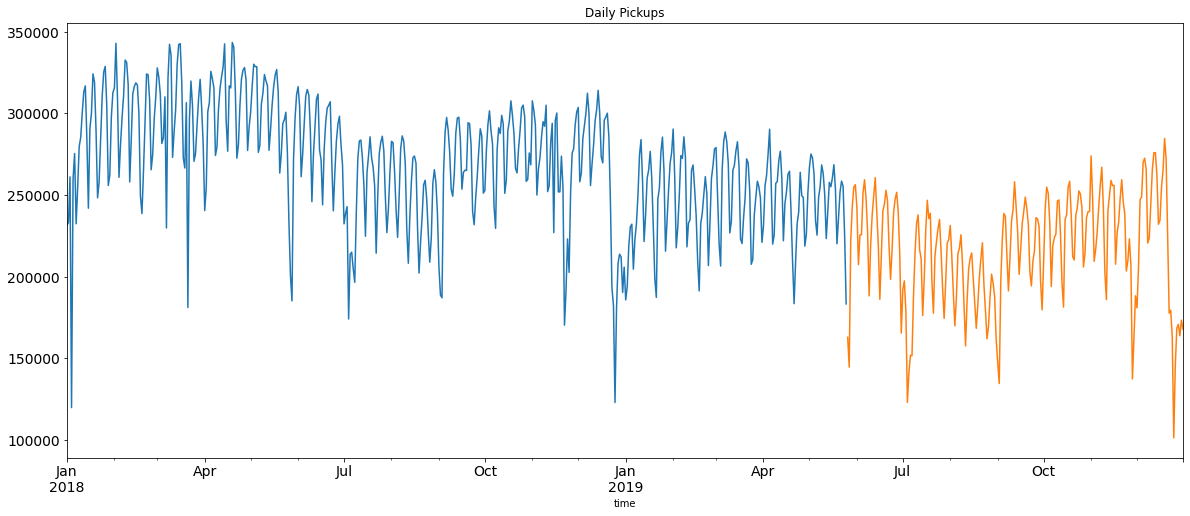

In [23]:
import matplotlib.pyplot as plt
explore1 = data[:int(0.7*(len(data)))]
explore2 = data[int(0.7*(len(data))):]
# ARIMA takes univariate data.
explore1 = explore1['pickups']
explore2 = explore2['pickups']
# Plot of Weekly_Sales with respect to years in train and test.
explore1.plot(figsize=(20,8), title= 'Daily Pickups', fontsize=14)
explore2.plot(figsize=(20,8), title= 'Daily Pickups', fontsize=14)
plt.show()

In [0]:
data = data.fillna(method='ffill')

<b> ADFULLER Test for Stationary</b>

In [25]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(data['pickups'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -1.8620831215235754
p-value: 0.35010313377312674
Critical Values:
	1%: -3.439593802573824
	5%: -2.865619356068967
	10%: -2.568942332870462


The p-value is not in 0.05. So the seasonality from the Data need to be removed. This will be done in Model BUilding Phase.

<b> Summary</b>
<p align="justify">Now I have completed feture engineering both for ARIMA and also for Xgboost, RandomForest and other regression techniques. Now I will apply cross validation and use MAPE as the benchmark for deciding the model which I will be using in my Flask application.</p>